In [8]:
#import all neccecery library
import pandas as pd
import langdetect
import matplotlib.pyplot as plt
import seaborn as sns

<h1>EDA</h1>

In [ ]:
train =pd.read_csv("../offence_data/train.csv")
test = pd.read_csv("../offence_data/test.csv")
valid = pd.read_csv("../offence_data/validation.csv") 
test_lebel = pd.read_csv("../offence_data/test_labels.csv") 


In [5]:
train.head()

,id,feedback_text,toxic,abusive,vulgar,menace,offense,bigotry
0,281d77b7bebc2201,:::Sounds good. Let me know when you're done ...,0,0,0,0,0,0
1,716aac7bf3c63db1,"""\nI say something, but it didn't actually con...",0,0,0,0,0,0
2,57cb318c6edcf10c,"""Agustina Barrientos]] \n | Modelo de Piñeiro ...",0,0,0,0,0,0
3,dc3bd70118d91b3a,FYI I enjoy licking strangers scrotal sacks......,1,0,1,0,0,0
4,cf10d41f2997d233,How do you get a site?\nMany penguins have ask...,0,0,0,0,0,0


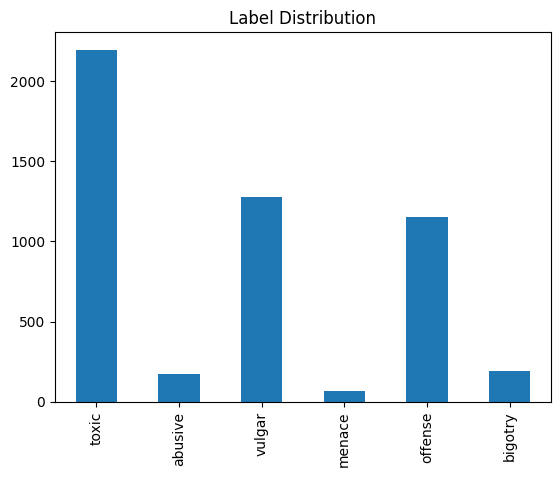

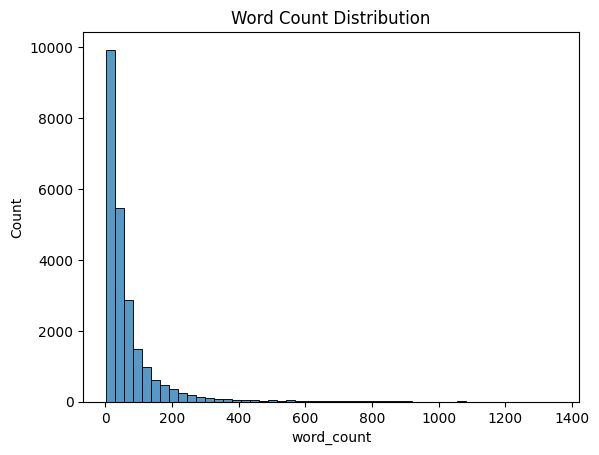

In [10]:
# Step 2: EDA
label_cols = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']
train[label_cols].sum().plot(kind="bar", title="Label Distribution")
plt.show()

train['word_count'] = train['feedback_text'].apply(lambda x: len(str(x).split()))
sns.histplot(train['word_count'], bins=50)
plt.title("Word Count Distribution")
plt.show()

In [17]:
test.head()

,id,content,lang
0,56496,"Bahar merhaba, Şu TV programı için bildiğin gi...",tr
1,18266,"Merhaba, başlık taşıma nedeniyle bir karışıklı...",tr
2,37852,kullanıcı ne mutlu türküm diyene yazmış ta...,tr
3,25075,Quand la plaisanterie sur le synopsis de ce fi...,fr
4,330,Não fosse seu esclarecimento no blog da Anne (...,pt


In [20]:
test['lang'].unique()

array(['tr', 'fr', 'pt', 'it', 'ru', 'es'], dtype=object)

In [27]:
languages = {}
for text in train['feedback_text'].dropna(): # drop NaN values to avoid errors
    try:
        lang = langdetect.detect(text)
        languages[lang] = languages.get(lang, 0) + 1
    except langdetect.LangDetectException:
            # Handle cases where language detection fails (e.g., short or ambiguous text)
            print(f"Language detection failed for text: '{text}'")
            pass # or use a default language, or add to a count of undetected items.


Language detection failed for text: '] // 02 // 03 // [http://www.webcitation.org/6MXxPPFVu 04'
Language detection failed for text: 'http://www.mediamonitors.net/edna47.html   http://www.freerepublic.com/forum/a3ad7b207707d.htm'
Language detection failed for text: ':http://knowyourmeme.com/memes/baneposting'
Language detection failed for text: 'ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂㄱㅇ ㅂ

In [28]:
languages

{'en': 22609,
 'es': 29,
 'tl': 29,
 'no': 33,
 'de': 93,
 'fa': 15,
 'so': 62,
 'id': 40,
 'et': 50,
 'fr': 67,
 'af': 55,
 'vi': 18,
 'cy': 37,
 'sl': 10,
 'tr': 21,
 'pt': 29,
 'sw': 10,
 'hr': 19,
 'fi': 10,
 'nl': 32,
 'it': 24,
 'cs': 3,
 'sv': 31,
 'da': 25,
 'ro': 20,
 'ar': 11,
 'pl': 8,
 'bn': 2,
 'ca': 19,
 'hu': 12,
 'lt': 2,
 'sq': 9,
 'sk': 7,
 'ru': 6,
 'he': 2,
 'ko': 2,
 'zh-cn': 1,
 'gu': 1,
 'ta': 1,
 'el': 3,
 'hi': 3,
 'th': 1,
 'lv': 1,
 'mk': 1,
 'ml': 2,
 'zh-tw': 1,
 'te': 1,
 'mr': 1,
 'bg': 1}

In [18]:
valid.head()

,id,feedback_text,lang,toxic
0,1203,İyi tamam olabilir. Balkanlar maddesini gelişt...,tr,0
1,5871,"Por dios, y la canción de John Lennon: http://...",es,1
2,3590,Selam. Öncelikle tebrik ederim... Bu arada ken...,tr,0
3,447,Leggiti tutte le discussioni. Magari cancellal...,it,1
4,6634,A LAS TOKITAS NOS VALE QUE LAS JONATICAS INSUL...,es,1
